In [1]:
!pip install denoising_diffusion_pytorch
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 50.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x8

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Subset
from tqdm import tqdm
import time
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [38]:
batch_size = 4
image_size = 32
num_epochs = 20
learning_rate = 1e-4

In [26]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [27]:
# 加载数据集(CIFAR10)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
subset_indices = list(range(500))
train_dataset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


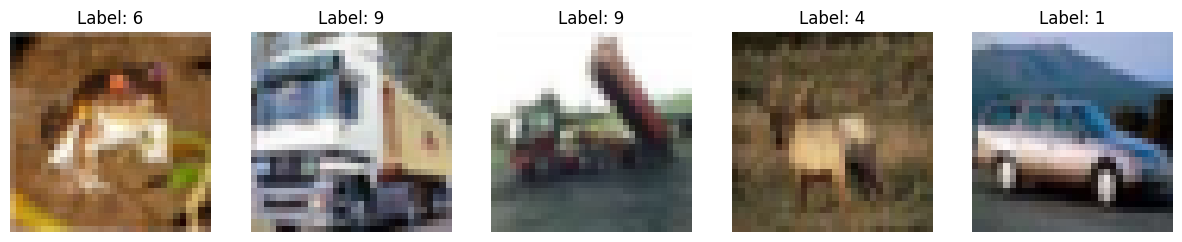

In [28]:
# 显示一些图像样本
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # 将形状从 (C, H, W) 转换为 (H, W, C)
        axes[i].imshow(image.numpy() * 0.5 + 0.5)  # 反归一化
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# 显示前5张图像
show_images(train_dataset)

In [29]:
class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [30]:
dip_model = DIP()
optimizer_dip = torch.optim.Adam(dip_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

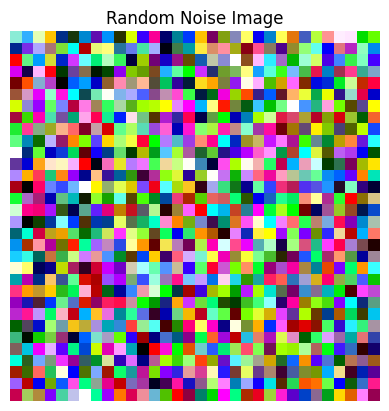

In [31]:
# 输入随机噪声图像
noise_image = torch.randn((1, 3, 32, 32))

plt.imshow(noise_image[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.title('Random Noise Image')
plt.axis('off')
plt.show()

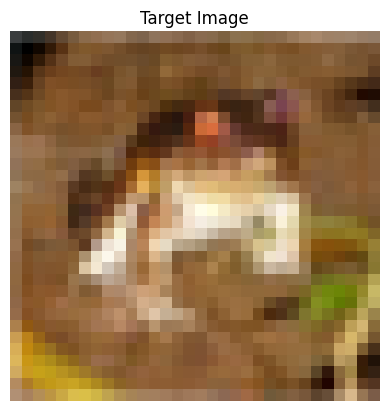

In [32]:
# 从数据集中获取一个目标图像
target_image, _ = train_dataset[0]  # 取第一个样本作为目标图像
target_image = target_image.unsqueeze(0)  # 增加一个batch维度

# 显示目标图像
plt.imshow(target_image[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.title('Target Image')
plt.axis('off')
plt.show()

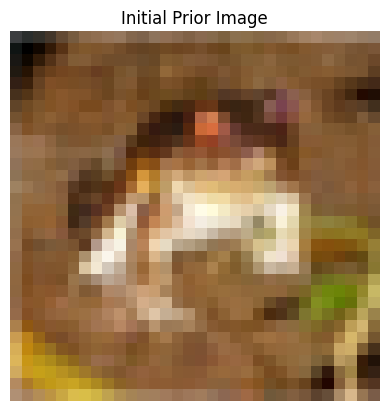

In [39]:
# 训练DIP模型
for epoch in range(2500):  # 训练的轮数可以根据实际情况调整
    optimizer_dip.zero_grad()
    output = dip_model(noise_image)
    loss = criterion(output, target_image)
    loss.backward()
    optimizer_dip.step()

# 生成初始先验图像
initial_prior = dip_model(noise_image).detach()

# 显示初始先验图像
plt.imshow(initial_prior[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.title('Initial Prior Image')
plt.axis('off')
plt.show()

In [35]:
ddpm_model = Unet(
    dim = 32,
    dim_mults = (1, 2, 4)
)

# 定义Gaussian Diffusion模型
diffusion = GaussianDiffusion(
    ddpm_model,
    image_size = 32,
    timesteps = 100,    # 扩散步骤数
    sampling_timesteps = 25    # 采样步骤数 (使用ddim加速推理)
)

In [36]:
# 将初始先验图像扩展为适当的形状
initial_prior_expanded = initial_prior.repeat(batch_size, 1, 1, 1)
# # 显示初始先验图像
# plt.imshow(initial_prior_expanded[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
# plt.title('Initial Prior Expanded Image')
# plt.axis('off')
# plt.show()


# 定义优化器
optimizer_ddpm = torch.optim.Adam(ddpm_model.parameters(), lr=learning_rate)

Epoch 1/20: 100%|██████████| 125/125 [00:41<00:00,  3.02it/s, Loss=0.183]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

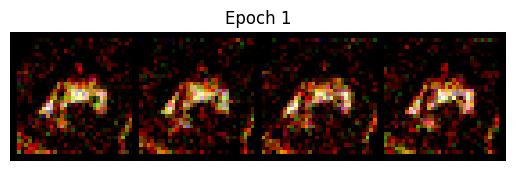

<ipython-input-40-d010a88d3790>:41: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(target_image_resized_np, sample_image_np, multichannel=True, data_range=1)


Epoch [1/20], PSNR: 7.7761, SSIM: 0.1078


Epoch 2/20: 100%|██████████| 125/125 [00:42<00:00,  2.91it/s, Loss=0.118]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

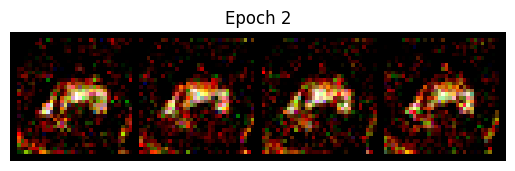

Epoch [2/20], PSNR: 7.7129, SSIM: 0.1042


Epoch 3/20: 100%|██████████| 125/125 [00:42<00:00,  2.95it/s, Loss=0.0974]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

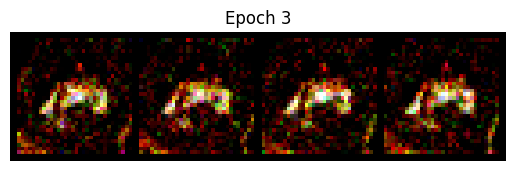

Epoch [3/20], PSNR: 7.7545, SSIM: 0.1033


Epoch 4/20: 100%|██████████| 125/125 [00:42<00:00,  2.97it/s, Loss=0.08]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

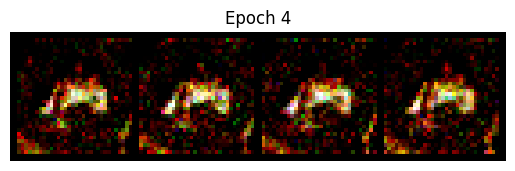

Epoch [4/20], PSNR: 7.7939, SSIM: 0.1067


Epoch 5/20: 100%|██████████| 125/125 [00:41<00:00,  2.99it/s, Loss=0.142]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

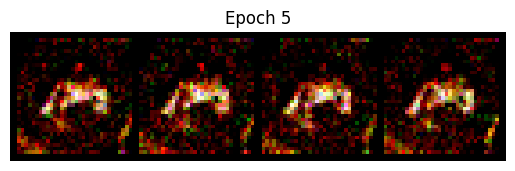

Epoch [5/20], PSNR: 7.7866, SSIM: 0.1150


Epoch 6/20: 100%|██████████| 125/125 [00:41<00:00,  3.01it/s, Loss=0.0347]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

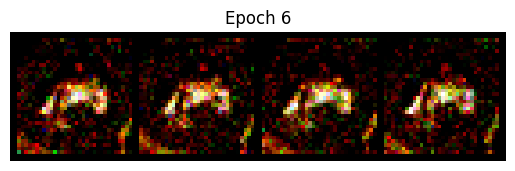

Epoch [6/20], PSNR: 7.7352, SSIM: 0.1023


Epoch 7/20: 100%|██████████| 125/125 [00:40<00:00,  3.10it/s, Loss=0.237]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

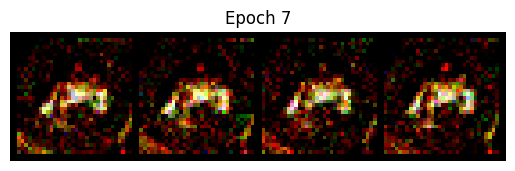

Epoch [7/20], PSNR: 7.7529, SSIM: 0.0993


Epoch 8/20: 100%|██████████| 125/125 [00:39<00:00,  3.15it/s, Loss=0.0125]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

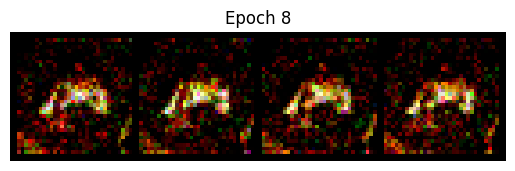

Epoch [8/20], PSNR: 7.7385, SSIM: 0.1059


Epoch 9/20: 100%|██████████| 125/125 [00:39<00:00,  3.16it/s, Loss=0.0459]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

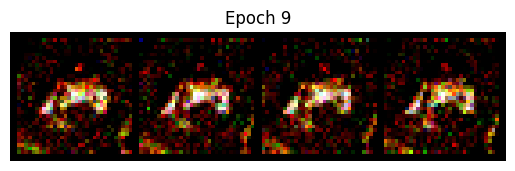

Epoch [9/20], PSNR: 7.7266, SSIM: 0.0919


Epoch 10/20: 100%|██████████| 125/125 [00:40<00:00,  3.06it/s, Loss=0.0366]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

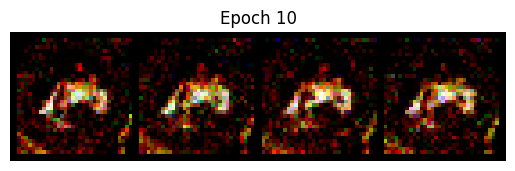

Epoch [10/20], PSNR: 7.7745, SSIM: 0.1024


Epoch 11/20: 100%|██████████| 125/125 [00:39<00:00,  3.14it/s, Loss=0.0848]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

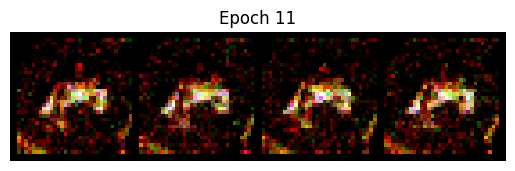

Epoch [11/20], PSNR: 7.7807, SSIM: 0.1077


Epoch 12/20: 100%|██████████| 125/125 [00:39<00:00,  3.16it/s, Loss=0.185]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

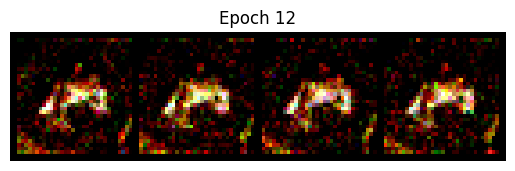

Epoch [12/20], PSNR: 7.7677, SSIM: 0.1077


Epoch 13/20: 100%|██████████| 125/125 [00:39<00:00,  3.16it/s, Loss=0.148]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

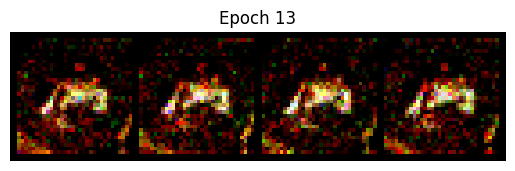

Epoch [13/20], PSNR: 7.7741, SSIM: 0.1025


Epoch 14/20: 100%|██████████| 125/125 [00:39<00:00,  3.16it/s, Loss=0.119]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

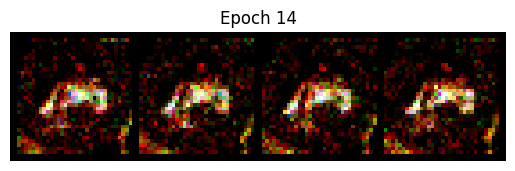

Epoch [14/20], PSNR: 7.7341, SSIM: 0.0927


Epoch 15/20: 100%|██████████| 125/125 [00:39<00:00,  3.16it/s, Loss=0.115]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

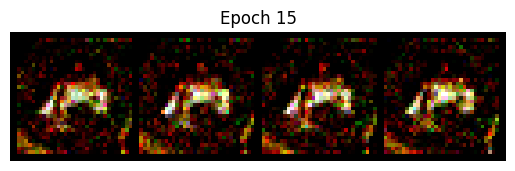

Epoch [15/20], PSNR: 7.7859, SSIM: 0.0907


Epoch 16/20: 100%|██████████| 125/125 [00:39<00:00,  3.16it/s, Loss=0.298]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

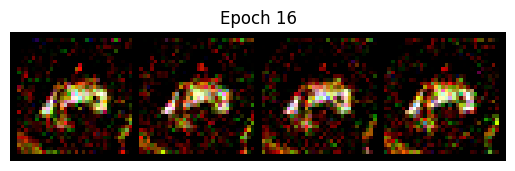

Epoch [16/20], PSNR: 7.7028, SSIM: 0.0861


Epoch 17/20: 100%|██████████| 125/125 [00:39<00:00,  3.17it/s, Loss=0.072]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

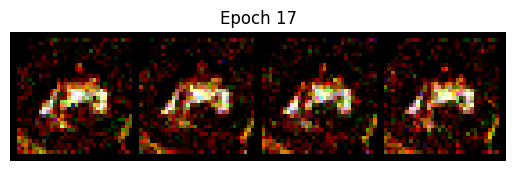

Epoch [17/20], PSNR: 7.7267, SSIM: 0.0864


Epoch 18/20: 100%|██████████| 125/125 [00:41<00:00,  3.00it/s, Loss=0.202]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

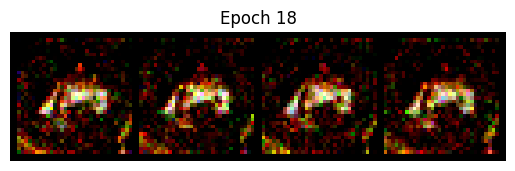

Epoch [18/20], PSNR: 7.7527, SSIM: 0.0901


Epoch 19/20: 100%|██████████| 125/125 [00:40<00:00,  3.09it/s, Loss=0.00736]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

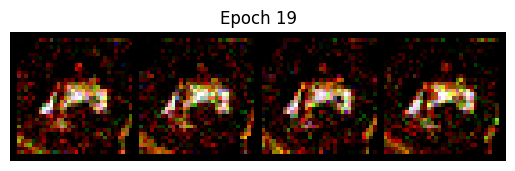

Epoch [19/20], PSNR: 7.7593, SSIM: 0.0848


Epoch 20/20: 100%|██████████| 125/125 [00:40<00:00,  3.06it/s, Loss=0.339]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

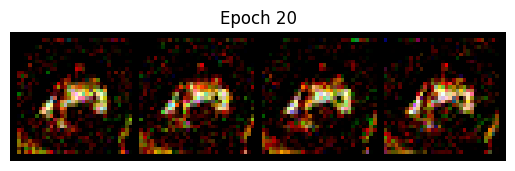

Epoch [20/20], PSNR: 7.8117, SSIM: 0.1083
Total training time: 878.15 seconds


In [40]:
# 開始計時
start_time = time.time()

# 訓練循環
for epoch in range(num_epochs):
    with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
        for batch_idx, batch in enumerate(train_dataloader):
            optimizer_ddpm.zero_grad()

            # 使用dip結果作爲輸入
            initial_prior_noisy = initial_prior_expanded + torch.randn_like(initial_prior_expanded) * 0.05

            # forward process
            loss = diffusion(initial_prior_noisy)

            # backward process
            loss.backward()
            optimizer_ddpm.step()

            pbar.set_postfix({'Loss': loss.item()})
            pbar.update(1)

    with torch.no_grad():
        sample_images = diffusion.sample(batch_size=batch_size)
        grid = torchvision.utils.make_grid(sample_images, nrow=4)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title(f'Epoch {epoch+1}')
        plt.axis('off')
        plt.show()

        # print(target_image.size())
        # print(sample_images.size())

        target_image_resized = transforms.Resize((image_size, image_size))(target_image)

        # 计算评估指标
        target_image_resized_np = target_image_resized.squeeze().permute(1, 2, 0).numpy()
        sample_image_np = sample_images[0].permute(1, 2, 0).cpu().numpy()

        psnr = peak_signal_noise_ratio(target_image_resized_np, sample_image_np, data_range=1)
        ssim = structural_similarity(target_image_resized_np, sample_image_np, multichannel=True, data_range=1)

        print(f"Epoch [{epoch+1}/{num_epochs}], PSNR: {psnr:.4f}, SSIM: {ssim:.4f}")

# 結束計時
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")